In [ ]:
# Just to connect with Google drive to read files from
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#for download the dataset
# Please fill the ... with the id of Dataset_JPV.zip in the google drive

download = drive.CreateFile({'id': '...'})
download.GetContentFile('drop_seg_final.zip')

# unzip your file
! unzip drop_seg_final.zip

In [ ]:
# just for uploading a trained model - When there is no need to train a new model
# get the shareable id same as the way of Dataset_JPV.zip

download = drive.CreateFile({'id': '...'})
download.GetContentFile('DS_trained_model.h5')

In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os, glob
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image as kImage

from keras import backend as K

In [ ]:
# load data function
def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        
        # Load ground-truth label and encode it to label 0 and 1
        y = kImage.load_img(Y_list[i], grayscale = True)
        y = kImage.img_to_array(y)
        y /= 255.0
        y = np.floor(y)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [ ]:
#Model structure
def initModel():
    ### Encoder
    net_input = Input(shape=(480,640,3))
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)
    
    for layer in vgg16.layers[:15]:
      layer.trainable = False
    
    x = vgg16.layers[-2].output # 2nd layer from the last, block5_conv3
    
    ### Decoder
    x = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# load data
dataset_path = os.path.join('train')
X, Y = getData(dataset_path)

# init the model
model = initModel()

early = tf.compat.v1.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)
reduce = tf.compat.v1.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

#training process
history = model.fit(X, Y, batch_size=10, epochs=10, verbose=2, validation_split=0.2, shuffle=True)
model.save('DS_trained_model.h5')

In [ ]:
dataset_path = os.path.join('test')
X, Y = getData(dataset_path)
print(X.shape)
# predict
#X_tf = tf.compat.v1.convert_to_tensor(X)
pred = model.predict(X, verbose=2, batch_size=32)
#print("Average Test Accuracy for Panel Dataset:" ,tf.compat.v1.Session().run(tf.compat.v1.keras.backend.mean(tf.compat.v1.keras.backend.equal(Y, tf.compat.v1.keras.backend.round(pred)))))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(21, 480, 640, 3)
1/1 - 1s


In [ ]:
import tf.compat.v1.keras.backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

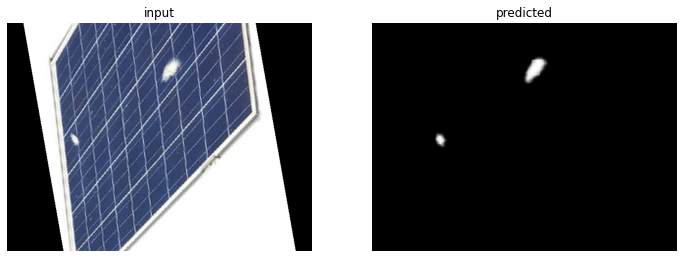

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = 4 # image index that you want to display of test images

img = np.empty(2, dtype=object)
img[0] = X[idx]
#img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])
img[1] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])

img[1] *= 255

title = ['input', 'predicted']

#title = ['input', 'ground-truth', 'result']
for i in range(2):
  plt.subplot(1, 2, i+1)
  if i==0:
    plt.imshow(img[0].astype('uint8'))
  else:
    plt.imshow(img[1], cmap='gray')
  
  plt.axis('off')
  plt.title(title[i])
plt.show()

In [ ]:
from tensorflow.compat.v1.keras.models import load_model
model = initModel()
model.set_weights('DS_trained_model.h5')

In [ ]:
from google.colab import files
files.download("DS_trained_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(X, Y)

1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9980


[0.0034414639230817556, 0.9979761838912964]